#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons. 
#### For testing the concept we use 2 neurons for which we have stored the responses to a given stimulus. 

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [175]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))

In [176]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [177]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)

<module 'PoissonProcessClasses' from '../code/PoissonProcessClasses.py'>

In [178]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [179]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [180]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)]).astype(int))

Creating filters:

In [181]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [182]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

Conditional Intensity (spike rate):

$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y_i + \sum_{j\ne i}I({\beta_{I}}_j)*y_j$$

$I(\beta_{I_j})$ corresponds to an interpolating filter with basis $I$ and  coefficients $\beta_{I_j}$ associated with the $y_j$ output. It is to assume that the post-spike history basis and the interpolating bases are the same: $H = I$. The intensity can then be rewritten as 

$$\lambda_{\beta}(i) = \exp\left(M_k \beta_k + \sum_{j=1}^n M_h {\beta_h}_j\right)$$

Creating a matrix of covariates:

<!---Simulating a neuron spike trains:-->

In [183]:
M_k = lk.construct_M_k(Stim,K,dt)

In [184]:
# creating a H-matrix for each response and merging them in one covariate matrix M_h
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))

M_h = np.hstack(tuple(M_h_list))

In [185]:
# combining all covariate matrices
M = np.hstack((M_k,M_h))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

In [186]:
model = PP.PPModel(M.T,dt = dt)

Setting initial parameters:

In [187]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])

coeff_h0 = np.zeros((5*nofCells,))

pars0 = np.hstack((coeff_k0,coeff_h0))

Fitting the likelihood for each neuron:

In [188]:
res_list = []
for y in y_list:
    res_list.append(model.fit(y,start_coef = pars0,method = 'Nelder-Mead'))

Optimization terminated successfully.
         Current function value: -332.706301
         Iterations: 5174
         Function evaluations: 6581
Optimization terminated successfully.
         Current function value: -438.302965
         Iterations: 7830
         Function evaluations: 9996


../code/PoissonProcessClasses.py:176: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.

/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:358: RuntimeWarning:

Method Nelder-Mead does not use gradient information (jac).

/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning:

Method Nelder-Mead does not use Hessian information (hess).



In [189]:
[print('\n Optimization results:\n'+str(res)) for res in res_list]


 Optimization results:
 success: True
     nit: 5174
       x: array([ -4.67511407e-02,  -6.94183492e-02,  -2.13121664e-02,
        -1.44529858e-02,   3.79938591e-02,   6.89742704e-02,
        -7.42620950e-02,   6.69600131e-02,  -4.67927981e-02,
         1.85278929e-02,   7.11780399e+00,   5.98345120e-02,
         1.27042264e+01,   2.79224958e+01,   3.53292977e+00,
        -3.56960275e+00,  -1.35616524e+01,  -2.06258228e+01,
         1.56286024e+01,  -1.31709437e+01])
    nfev: 6581
 message: 'Optimization terminated successfully.'
  status: 0
     fun: -332.70630099759336

 Optimization results:
 success: True
     nit: 7830
       x: array([  5.02809541e-02,  -5.74022401e-02,  -5.12629265e-02,
        -8.52186608e-02,  -1.03682134e-01,  -3.03290479e-02,
         4.42503604e-02,  -2.57695588e-02,   6.43794224e-02,
        -1.09696048e-02,   5.21288822e+00,   1.24485485e+01,
        -7.36058968e+00,  -2.99408874e+01,  -4.53894769e+00,
         9.73768313e+00,  -2.57064924e+01,   1.789

[None, None]

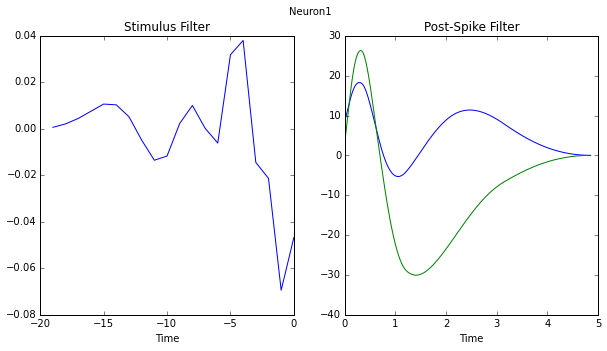

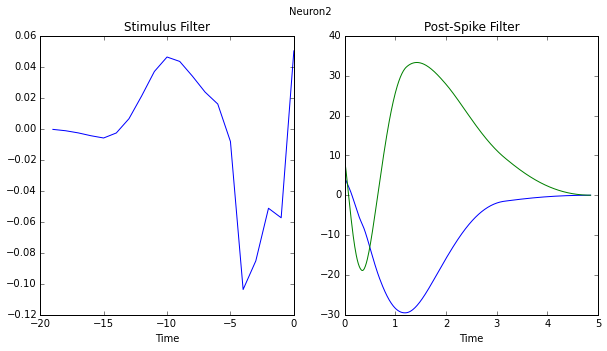

In [213]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = np.reshape(res_list[i].x[10:],(H.shape[1],nofCells))
    

    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted))
    axs[0].set_title('Stimulus Filter')
    axs[0].set_xlabel('Time')
    axs[1].plot(ht_domain,np.dot(H,h_coeff_predicted))
    axs[1].set_title('Post-Spike Filter')
    axs[1].set_xlabel('Time')
  